In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from matplotlib import colors

In [15]:
%%javascript
MathJax.Hub.Config({
    TeX: {equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Supose our data exhibits some symmetry with respect to some arbitrary group $\mathcal{G}$. Our goal is to design a quantum machine learning model such that it follows the same symmetry, either exactly or approximately. This require us to implement equivariant circuit structure in our design. To demonstrate how it can be done, let us do a simple example.

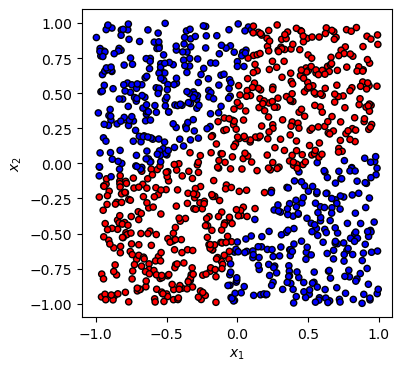

In [2]:
def Data_generate(samples, center=[[-1.0, 1.0],[1.0, -1.0]], radius=1.1):
    """
    Generates a dataset of points with 1/0 labels.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center[0]) < radius or np.linalg.norm(x - center[1]) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)

def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(x[:, 0], x[:, 1],  c=y, cmap=colors.ListedColormap(['red','blue']), s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
               
Xdata, ydata = Data_generate(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

The data here follows the $\mathcal{G} = \mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry, i.e. symmetric with respect to the two diagonal lines. There are no noise in this simple setup. It would be beneficial if our circuit output does not change (invariant) if the input data transform under the group. Before we discuss how this can be done in this specific case, we need to discuss what would be the approach in general.



# General approach

In Variational Quantum Algorithm (or quantum machine learning), the assumption is we have some initial state $|\psi_0 >$. Paramters $\theta$ and input data $\vec{x}$ are embedded into a unitary operator $U(\theta,\vec{x})$. The final state is given by:
$$|\psi(\theta,\vec{x}) >= U(\theta,\vec{x})|\psi_0 >
$$
For example, in data reuploading model, we have:
$$|\psi(\theta,\vec{x}) > = W_n(\theta)U(\vec{x})...W_1(\theta)U(\vec{x})W_0(\theta)|\psi_0 >
$$

Then, we have some observable $O$, which correspond to the label in classical machine learning. We obtain the expectation value.
$$y = <\psi(\theta,\vec{x})|O|\psi(\theta,\vec{x})>
$$
The final goal is that by choosing the appropariate observable,
$$L = 1-|y|^2
$$
is minimized (fidelity condition).

Now suppose we have some transformation under the group $g \in \mathcal{G}$. We want
$$y_g = <\psi(\theta,g\vec{x})|O|\psi(\theta,g\vec{x})> = y
$$
In another words. We would like the final expectation value to be invariant under the transformation.
One approach is to find a way such that this group action can be represented by some simple unitary transformation (in the end).
$$|\psi(\theta,g\vec{x})> = U_g|\psi(\theta,\vec{x})>
$$


Then if $U_g^\dagger O U_g = O$. The expectation value would not change.
From a logical point of view, the transformation should only change the embedding of the input data, that is
\begin{equation}
U(g\vec{x}) = U_gU(\vec{x})U_g^\dagger
\end{equation}
Note that this is a more natural assumption compare to $U_gU(\vec{x}) $, since this is a similarity transformation which introduced an equivilance class under the group.
The embedding done this way are said to be equivariant with respect to the group.

Furthermore, the choice of initial state is arbitrary, we could make $U_g|\psi_0 >= |\psi_0 >$ invariant under the symmetry, then the condition simply becomes
$$
U(\theta,g\vec{x}) = U_gU(\theta,\vec{x}) U_g^\dagger
$$

For reuploading models, this implies that final condition for this circuit then becomes
\begin{equation}
[U_g, W(\theta) ] = 0
\end{equation}


# Data embedding

For simplicty we choose our data embedding to be the $R_z$ gate, that is
$$U(x_1,x_2) = R_z(x_1)\otimes R_z(x_2)
$$
Then this also defines the unitary transformation under the group.
\begin{align*}
U(x_2,x_1) =&   R_z(x_2)\otimes R_z(x_1)\\
=& \text{SWAP}U(x_1,x_2)\text{SWAP}
\end{align*}

\begin{align*}
U(-x_1,-x_2) =&   R_z(-x_1)\otimes R_z(-x_2)\\
=& (X_1\otimes X_2)U(x_1,x_2)(X_1\otimes X_2)
\end{align*}

# Equivariant gate set

As stated before, the parametrized gates must commute with the group unitary representation. We can start with the standard universal gate set
$$
\{X_1,Y_1,Z_1,X_2,Y_2,Z_2, ZZ\}
$$
One can check that this gate set spans all possible unitary operations. Since the commutation relation translate to their exponentials, it is sufficient to only consider the basis. To find gates that commutes, we can do an average over all possible transformations. For arbitrary gate $T$, this means
$$\dfrac{1}{|\mathcal{G}|}U_g TU_g^\dagger
$$
This so called twirling formula projects the oprator onto another oprator which will commutes with every element of the group unitary representation. The proof is trivial.

For our particular case it is easy to show that there are only two elements in the basis
$$\{\dfrac{X_1+X_2}2,ZZ\}
$$

parametrization can then be done using exponentiation of the basis
$$
\{R_{X_1}(\theta_0)\otimes R_{X_2}(\theta_0),R_{ZZ}(\theta_1)\}
$$

# Inital state and Observable

The initial state invariant under this group representation is simple, $|+>\otimes |+>$ will do.

The observables, concerning two labels should satisfy the relation and orthogonal to each other.
I chose the density matrix corresponds to the state $|+>\otimes |+>$ and $|->\otimes -|->$.

In [10]:
# Put everything together. 

dev = qml.device("default.qubit", wires=2)

#the observables now have to be invriant under SWAP and X gates

label_0 = [[1], [1],[1], [1]]
label_1 = [[1], [-1],[-1], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)/2


@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    # prepare initial state in a invariant state 
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    for p in params:
        #embedding
        qml.RZ(x[0], wires=0)
        qml.RZ(x[1], wires=1)
        
        #Since exp(X_1+X_2) = RX_1 \cross RX_2
        qml.RX(p[0], wires=0)
        qml.RX(p[0], wires=1)
        
        #Rzz gates
        qml.CNOT([0,1])
        qml.RZ(p[1], wires=1)
        qml.CNOT([0,1])
        
    return qml.expval(qml.Hermitian(y, wires=[0,1]))

def density_matrix(state):
    return state * np.conj(state).T

def cost(params, x, y, state_labels=None):
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

def test(params, x, y, state_labels=None):
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [ ]:
# num_training = 500
# num_test = 2000
num_training = 200
num_test = 2000

Xdata, y_train = Data_generate(num_training)
X_train = Xdata
y_train = y_train

Xtest, y_test = Data_generate(num_test)
X_test = Xtest

# # Train using Adam optimizer and evaluate the classifier
num_layers = 5
learning_rate = 0.1
epochs = 20
batch_size = 64



# # initialize random weights
params = np.random.uniform(size=(num_layers, 2), requires_grad=True)
# best_params = np.load('best_params_task_VII.npy')
# params = best_params

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)
best_val_accuracy = accuracy_test
best_params = params.copy()

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)
    
    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)
    
    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    
    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.482793 | Train accuracy: 0.706000 | Test Accuracy: 0.687000
Epoch:  1 | Loss: 0.255390 | Train accuracy: 0.530500 | Test accuracy: 0.519000
Epoch:  2 | Loss: 0.242956 | Train accuracy: 0.639000 | Test accuracy: 0.616500
Epoch:  3 | Loss: 0.241170 | Train accuracy: 0.698000 | Test accuracy: 0.685500
Epoch:  4 | Loss: 0.240266 | Train accuracy: 0.671000 | Test accuracy: 0.653000
Epoch:  5 | Loss: 0.239675 | Train accuracy: 0.660000 | Test accuracy: 0.645000
Epoch:  6 | Loss: 0.239115 | Train accuracy: 0.679000 | Test accuracy: 0.657500


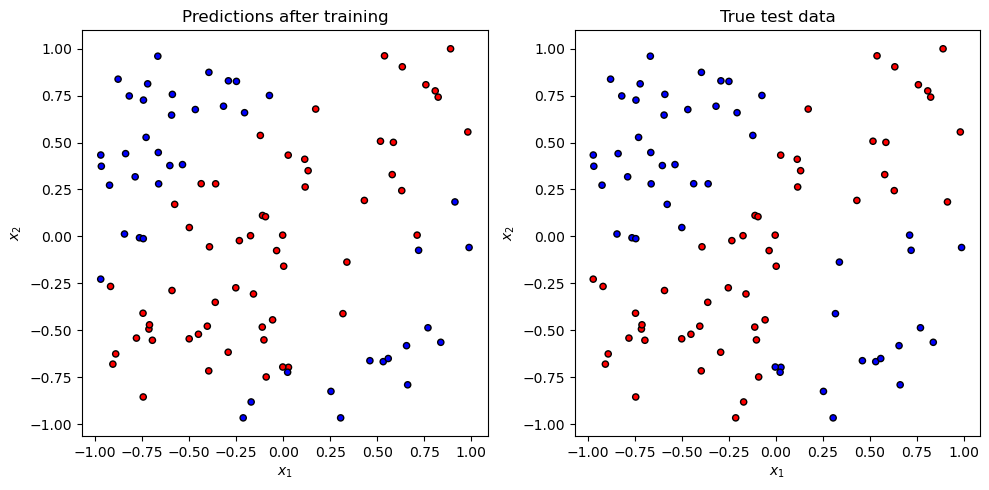

In [20]:
predicted_test, fidel_test = test(best_params, X_test, y_test, state_labels)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_data(X_test, predicted_test, fig, axes[0])
plot_data(X_test, y_test, fig, axes[1])
axes[0].set_title("Predictions after training")
axes[1].set_title("True test data")
plt.tight_layout()
plt.show()

In [14]:
#To show that the network respect input symmetry
D = density_matrix(state_labels[0])

T1 = qcircuit(params,X_test[0] ,D)
T2 = qcircuit(params,-X_test[0] ,D)
T3 = qcircuit(params,X_test[0, [1,0]] ,D)

print(T1 - T2 < 1e-5, T1 - T3 < 1e-5)

True True


In [16]:
circuit1_1 = qml.draw(qcircuit)(params, x[i], y)
print("\nCircuit1:")
print(circuit1_1)

TypeError: qcircuit() missing 3 required positional arguments: 'params', 'x', and 'y'